# User Behavior Analysis and Evaluation of a Design Change through an A/A/B Test in an Emerging Food Products Company

## Introduction

In the dynamic landscape of a burgeoning company specializing in food product sales, understanding user behavior and evaluating the impact of design changes in the mobile application are essential for optimizing the customer experience and enhancing conversion rates. This project is designed to address two key aspects: a comprehensive sales funnel analysis and the assessment of a typographic redesign through an A/A/B test.

The sales funnel analysis offers valuable insights into user interactions within the application. It identifies critical stages where users drop off and quantifies the proportion of users who complete the purchase process. This analysis is crucial for pinpointing areas for improvement and refining the customer journey to maximize conversions.

Simultaneously, the design team has proposed a typographic change aimed at improving the visual appeal and usability of the application. There is, however, a concern that the new design may be perceived as overwhelming by users. To address this concern, we implemented an A/A/B experiment. In this setup, users are divided into three groups: two control groups that retain the original typography and one test group that experiences the new typographic design. This experimental design allows us to assess whether the new typography influences user behavior and whether any observed differences are statistically significant.

The data analysis encompasses the following key steps:
1. **Importing Libraries and Loading Data:** Selecting and importing the necessary libraries, followed by a preliminary analysis of the dataset.
2. **Data Preparation:** Renaming columns, handling missing values, and creating additional columns to facilitate a thorough analysis.
3. **Data Exploration and Validation:** Counting events and users, and analyzing the temporal distribution of data to ensure data integrity.
4. **Sales Funnel Analysis:** Identifying critical events, calculating conversion rates, and detecting stages where users encounter issues.
5. **A/A/B Experiment Evaluation:** Comparing the control groups with the test group to determine if the typographic change significantly impacts user behavior.

Through this project, we aim to gain a deep understanding of user behavior within the application and make data-driven decisions to enhance design and functionality. The insights derived from this rigorous analysis will help guide future design improvements and optimize the user experience.

### Library Importation

In [1]:
# Importing libraries for data analysis and visualization

# Libraries for data manipulation
import pandas as pd
import numpy as np

# Libraries for data visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px
from plotly import graph_objects as go

# Libraries for statistical tests
from scipy import stats as st
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import chi2_contingency, ttest_ind
import statsmodels.stats.multitest as smm

# Libraries for date handling
import datetime as dt
from datetime import datetime

# Configuring the styles for the charts
sns.set(style="whitegrid")

# Libraries for displaying warnings
import warnings
warnings.filterwarnings('ignore')

### Data Loading

In [2]:
# File path for the data
file_path = r'C:\Users\Barbs\Documents\GitHub\English\User Behavior Analysis for Food Products App\logs_exp_us.csv'

# Load the data into a pandas DataFrame
data = pd.read_csv(file_path, delimiter='\t')

# Display the first few rows of the DataFrame to verify data loading
print("Preliminary view of the data:")
display(data.head())

Preliminary view of the data:


,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


After reviewing the preliminary view of the data, we noticed that the column headers are separated by tabs instead of commas, which makes the initial reading of the data more challenging. We suggest renaming the columns to lowercase with underscores for better readability and consistency. Additionally, it would be beneficial to conduct a more detailed exploration of the unique values in each column to better understand the variability and distribution of the data.

Regarding the content of the data, we can observe that the dataset contains records of events, each associated with an event name, a unique device ID, a timestamp, and an experiment ID. The most common events include the appearance of the main screen, offers, shopping cart, and successful payments. Some users experience multiple events, such as the main screen appearing followed by a purchase. Additionally, the data seems to be divided into different experimental groups identified by a specific ID. This tabular structure provides an initial insight into the content and organization of the data.

## Data Preparation

In [3]:
def prepare_data(df):
    """
    Function to prepare the DataFrame for analysis.
    
    Parameters:
    df (DataFrame): The DataFrame to prepare.
    
    Returns:
    DataFrame: The prepared DataFrame.
    """
    # Check if the expected columns are in the DataFrame
    expected_columns = {'EventName', 'DeviceIDHash', 'EventTimestamp', 'ExpId'}
    if not expected_columns.issubset(df.columns):
        missing_cols = expected_columns - set(df.columns)
        raise ValueError(f"The following columns are missing in the DataFrame: {missing_cols}")

    # Rename the columns to lowercase with underscores
    df = df.rename(columns={
        'EventName': 'event_name',
        'DeviceIDHash': 'device_id_hash',
        'EventTimestamp': 'event_timestamp',
        'ExpId': 'exp_id'
    })

    # Check data types and missing values
    print("Data types and missing values before correction:\n")
    print(df.dtypes)
    print("\nMissing values by column:\n")
    print(df.isnull().sum())
    print("\n" + "-"*50 + "\n")

    # Correct missing values if necessary
    df = df.fillna({
        'event_name': 'unknown_event',
        'device_id_hash': 0,
        'event_timestamp': 0,
        'exp_id': -1
    })

    # Convert the timestamp column to datetime type
    try:
        df['event_timestamp'] = pd.to_datetime(df['event_timestamp'], unit='s', errors='coerce')
    except Exception as e:
        print(f"Error converting the event_timestamp column to datetime: {e}")

    # Remove rows with unconverted dates if they exist
    df = df.dropna(subset=['event_timestamp'])

    # Add date and time columns, as well as a separate column for dates
    df['date'] = df['event_timestamp'].dt.date
    df['time'] = df['event_timestamp'].dt.time

    # Check data types and missing values after correction
    print("Data types and missing values after correction:\n")
    print(df.dtypes)
    print("\nMissing values by column:\n")
    print(df.isnull().sum())
    print("\n" + "-"*50 + "\n")
    
    # Check for duplicate values
    duplicates = df.duplicated()
    print("Number of duplicate rows:", duplicates.sum()) # Displays the number of duplicate rows
    print("\n" + "-"*50 + "\n")

    # Remove duplicate rows if any
    df = df.drop_duplicates()

    return df

# Prepare the data
prepared_data = prepare_data(data)

# Display the first few rows of the prepared DataFrame
print("Preliminary view of the prepared data:\n")
display(prepared_data.head())

Data types and missing values before correction:

event_name         object
device_id_hash      int64
event_timestamp     int64
exp_id              int64
dtype: object

Missing values by column:

event_name         0
device_id_hash     0
event_timestamp    0
exp_id             0
dtype: int64

--------------------------------------------------

Data types and missing values after correction:

event_name                 object
device_id_hash              int64
event_timestamp    datetime64[ns]
exp_id                      int64
date                       object
time                       object
dtype: object

Missing values by column:

event_name         0
device_id_hash     0
event_timestamp    0
exp_id             0
date               0
time               0
dtype: int64

--------------------------------------------------

Number of duplicate rows: 413

--------------------------------------------------

Preliminary view of the prepared data:



,event_name,device_id_hash,event_timestamp,exp_id,date,time
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25,04:43:36
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25,11:11:42
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25,11:28:47
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25,11:28:47
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25,11:48:42


After correcting the data types and reviewing the missing values in the dataset, we observe that all columns now have the appropriate data types, and no missing values are present. Before the correction, the timestamp and date columns were represented as integers instead of datetime objects, which complicated time series analysis and date manipulation. After the correction, the date and time columns have been added correctly, making it easier to understand the time period covered by the data. 

In the preliminary view of the prepared data, we can see that each event is now associated with an accurate timestamp and has been properly split into separate columns for date and time. This enhances readability and facilitates future analyses.


## Data Exploration and Validation

### How Many Events Are in the Records?

In [4]:
# Total number of events in the records
total_events = prepared_data.shape[0]
print(f"Total number of events in the records: {total_events}\n")

# Breakdown of events by type
events_by_type = prepared_data['event_name'].value_counts()
print(f"Events by type:\n{events_by_type}\n")

Total number of events in the records: 243713

Events by type:
event_name
MainScreenAppear           119101
OffersScreenAppear          46808
CartScreenAppear            42668
PaymentScreenSuccessful     34118
Tutorial                     1018
Name: count, dtype: int64



After reviewing the quantity and types of events in the records, we observe that there is a total of 244,126 events logged, distributed across five different event types. The event types include `MainScreenAppear`, `OffersScreenAppear`, `CartScreenAppear`, `PaymentScreenSuccessful`, and `Tutorial`. This diversity of events provides a broad view of user interactions with the platform or application in question.

### How Many Users Are in the Records?

In [5]:
# Total number of users in the records
total_users = prepared_data['device_id_hash'].nunique()
print(f"Total number of users in the records: {total_users}")

Total number of users in the records: 7551


After analyzing the dataset, we identified a total of 7,551 unique users recorded in the system. This number represents the total number of unique users who participated in the logged events during the considered time period.

### What Is the Average Number of Events per User?

In [6]:
# Average number of events per user
events_per_user = prepared_data.groupby('device_id_hash')['event_name'].count().reset_index()
events_per_user.columns = ['user_id', 'count']
average_events_per_user = events_per_user['count'].mean()
print(f"Average number of events per user: {average_events_per_user:.2f}")

Average number of events per user: 32.28


After calculating the average number of events per user, we found that each user participated in approximately 32.33 events during the considered time period. This value provides a general measure of user activity on the platform during the analyzed period.

### What Time Period Is Covered by the Data? Maximum and Minimum Dates.

In [7]:
# Find the minimum and maximum dates
min_date = prepared_data['event_timestamp'].min()
max_date = prepared_data['event_timestamp'].max()
print(f"Time period covered by the data: from {min_date} to {max_date}")


Time period covered by the data: from 2019-07-25 04:43:36 to 2019-08-07 21:15:17


The dataset covers a period from July 25, 2019, at 04:43:36 to August 7, 2019, at 21:15:17. This time range represents the interval during which events were recorded on the platform.

### Histogram by Date and Time

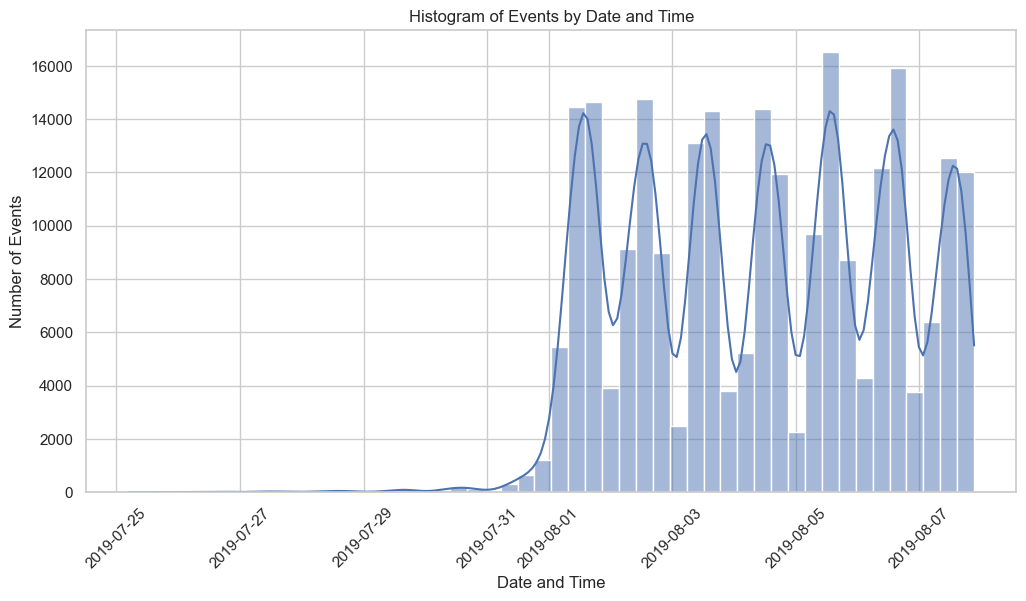

In [8]:
# Plot histogram by date and time
plt.figure(figsize=(12, 6))
sns.histplot(prepared_data['event_timestamp'], bins=50, kde=True)
plt.xlabel('Date and Time')
plt.ylabel('Number of Events')
plt.title('Histogram of Events by Date and Time')
plt.xticks(rotation=45)
plt.show()



After analyzing the data, we observed that the minimum date in our records is July 25, 2019, at 04:43:36. However, when examining the histogram of events by date and time, we noticed a lack of uniformity in the distribution of data throughout the entire period. This disparity suggests that the data is not equally complete for the entire time interval. From August 1, 2019, onwards, the data begins to show more consistency and completeness, up until August 7, 2019. Therefore, we decided to disregard data prior to August 1, 2019, to ensure the integrity of our analysis and avoid biases in the overall picture.

Additionally, when plotting the histogram of events by date and time, we observed a significant increase in the number of events recorded towards the end of July and the beginning of August, indicating higher activity during this period. To investigate this sudden spike in more detail, it is necessary to generate another visualization that allows us to examine this peak in event frequency with greater precision.


### Moment When the Data Becomes Complete


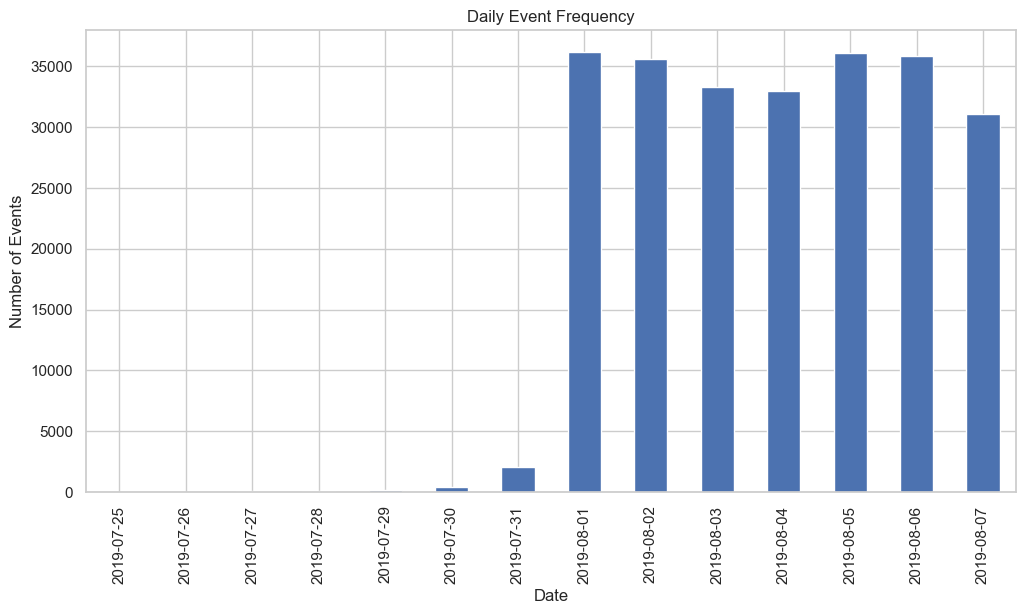

In [9]:
# Group the data by date to see the daily event frequency
daily_frequency = prepared_data['date'].value_counts().sort_index()

# Plot the daily event frequency
plt.figure(figsize=(12, 6))
daily_frequency.plot(kind='bar')
plt.xlabel('Date')
plt.ylabel('Number of Events')
plt.title('Daily Event Frequency')
plt.xticks(rotation=90)
plt.show()

# Determine the date from which the data becomes consistent
# We assume that data is complete starting from a date where the frequency is stable.
complete_data_start_date = daily_frequency[daily_frequency > 100].index[0]  # Adjust the threshold as needed
complete_data = prepared_data[prepared_data['date'] >= complete_data_start_date]

After grouping the data by date and plotting the daily event frequency, we identified a pattern in the distribution of events over time. By examining the daily frequency chart, we noticed that starting from a specific date, the event frequency becomes more stable, indicating that the data is consistent from that point onward. Using a threshold of 100 events per day, we determined the start date of this stability in the data. Therefore, we created a new dataset called "complete_data," which includes only the records from this date onward, ensuring the integrity and reliability of our subsequent analyses.

### Are Many Events and Users Lost by Excluding the Older Data?

In [10]:
# Convert the string to a datetime.date object
start_date = datetime.strptime('2019-08-01', '%Y-%m-%d').date()

# Filter the DataFrame to include only data from August 1, 2019, onwards
complete_data = prepared_data[prepared_data['date'] >= start_date]

# Calculate lost events and users by excluding older data
lost_events = total_events - complete_data.shape[0]
lost_users = total_users - complete_data['device_id_hash'].nunique()

# Calculate the percentage of lost events and users
percentage_lost_events = (lost_events / total_events) * 100
percentage_lost_users = (lost_users / total_users) * 100

# Print results
print(f"Lost events by excluding older data: {lost_events}")
print(f"Percentage of lost events: {percentage_lost_events:.2f}%")
print("\n" + "-"*50 + "\n")
print(f"Lost users by excluding older data: {lost_users}")
print(f"Percentage of lost users: {percentage_lost_users:.2f}%")

Lost events by excluding older data: 2826
Percentage of lost events: 1.16%

--------------------------------------------------

Lost users by excluding older data: 17
Percentage of lost users: 0.23%


After applying the filter to exclude the older data, a minimal loss in both events and users was observed. Specifically, 2,826 events were lost, which represents approximately 1.16% of the total events, and 17 users were lost, equivalent to 0.23% of the total users. Although these figures are not significant in absolute terms, it is crucial to consider them when interpreting the analysis results. This filtering may influence the representativeness of the sample and, consequently, the conclusions drawn from the study. Therefore, it is recommended to take these losses into account when conducting subsequent analyses and interpreting the results to ensure their validity and reliability.

### Users in the Three Experimental Groups

In [11]:
# Check that users exist in all three experimental groups
experimental_groups = complete_data['exp_id'].unique()
print(f"Experimental groups present in the data: {experimental_groups}")

print("\n" + "-"*50 + "\n")

# Number of users per experimental group
users_per_group = complete_data.groupby('exp_id')['device_id_hash'].nunique()
print(f"Number of users per experimental group:\n{users_per_group}")

print("\n" + "-"*50 + "\n")

# Count events by experiment
events_per_experiment = complete_data.groupby('exp_id')['event_name'].count()
print(f"Number of events per experiment:\n{events_per_experiment}")

Experimental groups present in the data: [246 247 248]

--------------------------------------------------

Number of users per experimental group:
exp_id
246    2484
247    2513
248    2537
Name: device_id_hash, dtype: int64

--------------------------------------------------

Number of events per experiment:
exp_id
246    79302
247    77022
248    84563
Name: event_name, dtype: int64


After conducting the analysis, it was found that the data includes users from all three experimental groups, identified as 246, 247, and 248. Additionally, the number of users per experimental group varies slightly, with 2,484 users in group 246, 2,513 in group 247, and 2,537 in group 248. Similarly, when examining the number of events recorded in each experiment, a similar distribution was observed, with 79,302 events in group 246, 77,022 in group 247, and 84,563 in group 248. These figures suggest an equitable distribution of users and events across the different experimental groups, providing a solid basis for comparative analysis between them.

## Event Funnel

### Events and Occurrence Frequency: Ordered by Frequency

In [12]:
# Observe the events in the records and their occurrence frequency
event_frequency = complete_data['event_name'].value_counts().reset_index()
event_frequency.columns = ['Event', 'Frequency']
event_frequency = event_frequency.sort_values(by='Frequency', ascending=False)
print("Events and their occurrence frequency:")
display(event_frequency)

print("\n" + "-"*50 + "\n")

# Create pivot table
frequency = event_frequency.sort_values('Frequency', ascending=False)

# Define blue color palette
color_map = ['#99ccff', '#85b3ff', '#709bff', '#5c82ff', '#476aff']

# Create vertical bar chart
trace = go.Bar(
    x=frequency['Event'],
    y=frequency['Frequency'],
    marker=dict(color=color_map)
)

# Define layout
layout = go.Layout(
    title='Event Frequency',
    xaxis=dict(title='Event Name'),
    yaxis=dict(title='Frequency'),
    margin=dict(l=150, r=50, b=50, t=50),
)

# Create figure
fig = go.Figure(data=[trace], layout=layout)

# Show the figure
fig.show()

Events and their occurrence frequency:


,Event,Frequency
0,MainScreenAppear,117328
1,OffersScreenAppear,46333
2,CartScreenAppear,42303
3,PaymentScreenSuccessful,33918
4,Tutorial,1005



--------------------------------------------------



The table showing the frequency of each event reveals that the most common interaction among users is "MainScreenAppear," with a notably high number of around 117,328 occurrences. This is followed by "OffersScreenAppear" with approximately 46,333 events, indicating a significant level of interaction related to offers. On the other hand, "Tutorial" is the least frequent event, suggesting that participation in tutorials may be less common or a lower priority for users.

### Users per Event: Ordered by Participation and Proportion

In [13]:
# Find the number of users who performed each event
users_per_event = complete_data.groupby('event_name')['device_id_hash'].nunique().reset_index()
users_per_event.columns = ['Event', 'Users']
users_per_event = users_per_event.sort_values(by='Users', ascending=False)

# Calculate the proportion of users who performed each event at least once
total_users = complete_data['device_id_hash'].nunique()
users_per_event['Proportion'] = users_per_event['Users'] / total_users

print("Number of users and proportion per event:")
display(users_per_event)

# Sort by the number of users
users_per_event = users_per_event.sort_values(by='Users', ascending=False)

print("\n" + "-"*50 + "\n")

# Create vertical bar chart
trace = go.Bar(
    x=users_per_event['Event'],
    y=users_per_event['Users'],
    marker=dict(color=color_map)  # Using the same color palette
)

# Define layout
layout = go.Layout(
    title='Number of Users per Event',
    xaxis=dict(title='Event Name'),
    yaxis=dict(title='Number of Users'),
    margin=dict(l=150, r=50, b=50, t=50),
)

# Create figure
fig = go.Figure(data=[trace], layout=layout)

# Show the figure
fig.show()

Number of users and proportion per event:


,Event,Users,Proportion
1,MainScreenAppear,7419,0.984736
2,OffersScreenAppear,4593,0.609636
0,CartScreenAppear,3734,0.495620
3,PaymentScreenSuccessful,3539,0.469737
4,Tutorial,840,0.111495



--------------------------------------------------



The table shows the number of users who participated in each event, as well as the proportion of users who performed each action at least once. Observing the data, it is evident that most users interacted with the "MainScreenAppear" event, with a total of 7,419 users and a proportion of 98.47%. This suggests that nearly all users viewed the main screen at some point. On the other hand, the "Tutorial" event had the fewest users, with 840, and a proportion of 11.15%. This relatively low proportion may indicate that only a fraction of users completed the tutorial. The data provides valuable insights into how users engage with each event and their level of participation on the platform.

### Event Sequence and Consistency in the Action Sequence

In [14]:
# Calculate the proportion of users advancing through the event funnel
event_funnel = ['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful', 'Tutorial']
advance_proportions = []

for i in range(len(event_funnel) - 1):
    current_event = event_funnel[i]
    next_event = event_funnel[i + 1]
    
    current_users = complete_data[complete_data['event_name'] == current_event]['device_id_hash'].nunique()
    next_users = complete_data[complete_data['event_name'] == next_event]['device_id_hash'].nunique()
    
    advance_proportion = next_users / current_users if current_users > 0 else 0
    advance_proportions.append(advance_proportion)

# Display the proportions of users advancing through the event funnel
for i in range(len(advance_proportions)):
    current_event = event_funnel[i]
    next_event = event_funnel[i + 1]
    advance_proportion = advance_proportions[i]
    
    print(f"Proportion of users advancing from '{current_event}' to '{next_event}': {advance_proportion:.2%}")

print("\n" + "-"*127 + "\n")

# Define Seaborn color palette
sns.set_palette("muted")

# Get the number of unique users for each event in the correct order
users_per_event = [complete_data[complete_data['event_name'] == event]['device_id_hash'].nunique() for event in event_funnel]

# Visualize the event funnel with Plotly
fig = go.Figure(go.Funnel(
    y=event_funnel,
    x=users_per_event,
    textposition='inside',
    textinfo='value+percent previous'
))

fig.update_layout(title='Event Funnel',
                  xaxis_title='Number of Users',
                  yaxis_title='Event')

fig.show()

Proportion of users advancing from 'MainScreenAppear' to 'OffersScreenAppear': 61.91%
Proportion of users advancing from 'OffersScreenAppear' to 'CartScreenAppear': 81.30%
Proportion of users advancing from 'CartScreenAppear' to 'PaymentScreenSuccessful': 94.78%
Proportion of users advancing from 'PaymentScreenSuccessful' to 'Tutorial': 23.74%

-------------------------------------------------------------------------------------------------------------------------------



The event funnel analysis reveals the proportions of users advancing from one stage to another in the application. We found that most users who reach the main screen (MainScreenAppear) proceed to the offers screen (OffersScreenAppear) with a proportion of 61.91%. Additionally, the transition to the cart screen (CartScreenAppear) shows an even higher proportion of 81.30%. Finally, the vast majority of users who view the cart proceed to complete a successful payment (PaymentScreenSuccessful) with a proportion of 94.78%. However, the proportion of users who move from completing a successful payment to viewing a tutorial (Tutorial) is significantly lower, with only 23.74%.

### Proportion of Users Advancing Through the Event Funnel

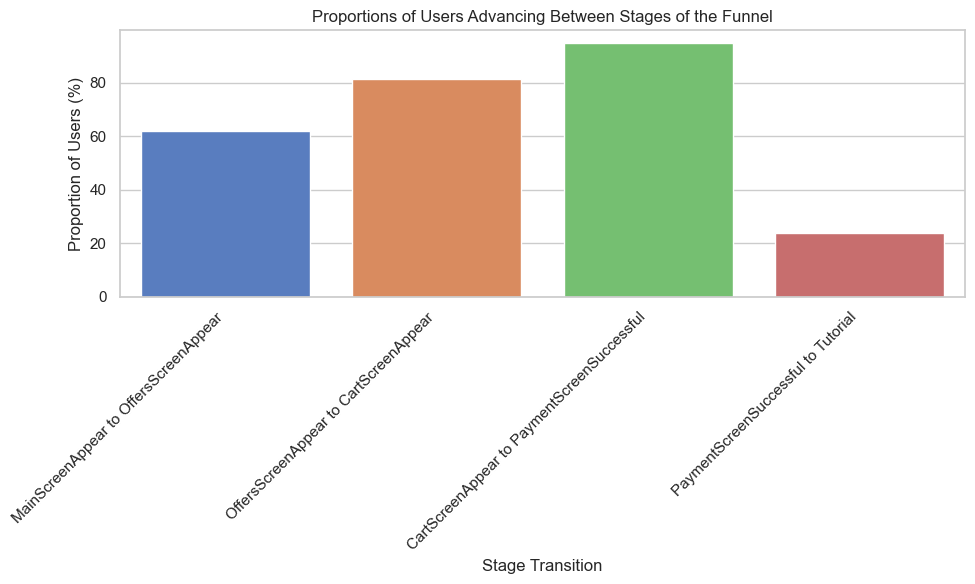

In [15]:
# Use the results from advance_proportions to create a bar chart
stages = [f"{event_funnel[i]} to {event_funnel[i+1]}" for i in range(len(event_funnel) - 1)]
proportions = [proportion * 100 for proportion in advance_proportions]  # Convert to percentage

# Create a bar chart to visualize the proportions of users advancing between stages
plt.figure(figsize=(10, 6))
sns.barplot(x=stages, y=proportions, palette="muted")
plt.xlabel('Stage Transition')
plt.ylabel('Proportion of Users (%)')
plt.title('Proportions of Users Advancing Between Stages of the Funnel')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

The bar chart provides a clear visualization of the proportions of users advancing between the stages of the event funnel. It shows that the majority of users advance significantly from viewing the main screen to successfully completing a payment. However, the proportion of users who proceed to view the tutorial after a successful payment is notably low compared to the previous stages in the funnel. This information highlights critical points in the funnel where optimization efforts can be focused to improve the user experience and maximize conversion.

### User Drop-Off Analysis by Stage

The stage with the highest user drop-off is stage 1


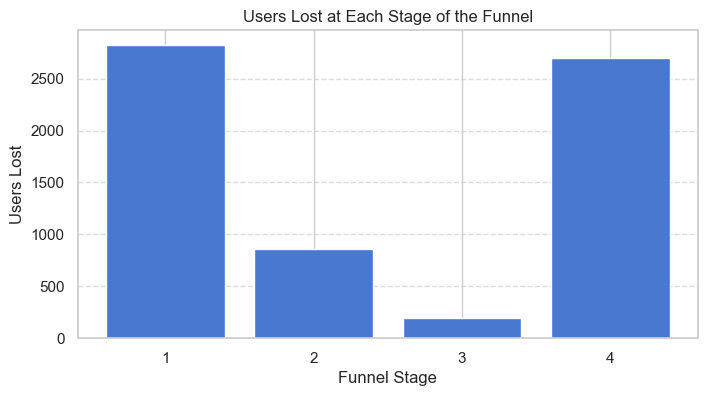

In [16]:
# Get the number of users at the start of the funnel (in the first stage)
initial_users = users_per_event[0]

# Calculate the number of users lost at each stage of the funnel
users_per_stage = [initial_users]  # Number of users at the start of the funnel
users_lost_per_stage = []

# Calculate users lost at each stage
for i in range(1, len(users_per_event)):
    users_lost = users_per_stage[i-1] - users_per_event[i]
    users_lost_per_stage.append(users_lost)
    users_per_stage.append(users_per_event[i])

# Find the stage with the highest user drop-off
stage_max_loss = users_lost_per_stage.index(max(users_lost_per_stage)) + 1

# Display results
print(f"The stage with the highest user drop-off is stage {stage_max_loss}")

# Funnel stages
funnel_stages = range(1, len(users_lost_per_stage) + 1)

# Define Seaborn color palette
sns.set_palette("muted")

# Create bar chart
plt.figure(figsize=(8, 4))
plt.bar(funnel_stages, users_lost_per_stage)
plt.xlabel('Funnel Stage')
plt.ylabel('Users Lost')
plt.title('Users Lost at Each Stage of the Funnel')
plt.xticks(funnel_stages)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

By identifying the stage of the funnel where the most users drop off, we can focus our efforts on optimizing that specific stage to reduce the abandonment rate. This information allows us to target retention strategies and improve the user experience at this crucial stage of the event funnel, potentially increasing user conversion and retention on the platform.

### Percentage of Users Completing the Funnel

11.32% of users complete the entire journey from their first event to payment.


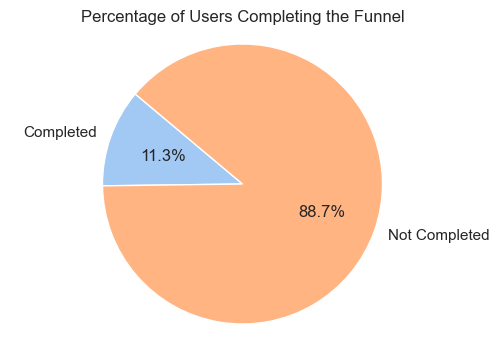

In [17]:
# Calculate the percentage of users who complete the funnel
percentage_completed = (users_per_event[-1] / initial_users) * 100

# Display results
print(f"{percentage_completed:.2f}% of users complete the entire journey from their first event to payment.")

# Data for the chart
labels = ['Completed', 'Not Completed']
data = [percentage_completed, 100 - percentage_completed]

# Colors using the Seaborn palette
colors = sns.color_palette('pastel')

# Create the pie chart
plt.figure(figsize=(6, 4))
plt.pie(data, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Percentage of Users Completing the Funnel')
plt.axis('equal')  # Ensures the chart is a circle
plt.show()

By calculating the percentage of users who complete the entire funnel from the first event to payment, we obtain a key measure of the overall effectiveness of the event funnel. This percentage indicates how successful our funnel is in guiding users through all stages to the desired conversion. A high percentage of users completing the funnel suggests a smooth and efficient experience, while a low percentage may highlight areas for improvement in the funnel flow and user experience.

## Analyze the Results of the Experiment

### Contar Usuarios en Cada Grupo

In [18]:
# Verify unique values in the 'exp_id' column
print("Unique values in 'exp_id':", complete_data['exp_id'].unique())

# Count the number of users in each group
users_per_group = complete_data.groupby('exp_id')['device_id_hash'].nunique().reset_index()
users_per_group.columns = ['Group', 'Users']
print("Number of users per group:")
display(users_per_group)

Unique values in 'exp_id': [246 247 248]
Number of users per group:


,Group,Users
0,246,2484
1,247,2513
2,248,2537


It has been verified that the values in the 'exp_id' column are unique and correct, displaying the values [246, 247, 248]. Additionally, the number of unique users in each group was counted using 'device_id_hash', with the results showing 2,484 users in group 246, 2,513 in group 247, and 2,537 in group 248.

### Statistically Significant Difference Between Control Groups

The most popular event is: MainScreenAppear
Users who performed 'MainScreenAppear' in group 246: 2450 (98.63%)
Users who performed 'MainScreenAppear' in group 247: 2476 (98.53%)
P-value of the z-test for proportions: 0.7571
There is no statistically significant difference between control groups 246 and 247.

-------------------------------------------------------------------------------------------------------------------------------



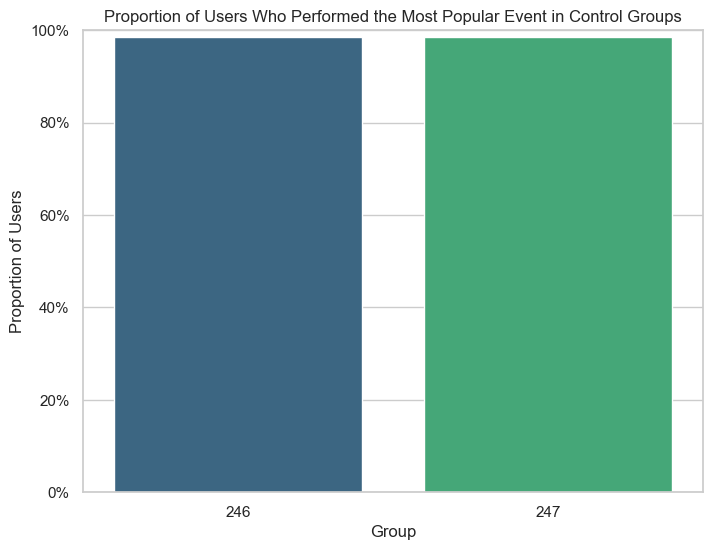

In [19]:
# Select the most popular event
most_popular_event = complete_data['event_name'].value_counts().idxmax()
print(f"The most popular event is: {most_popular_event}")

# Filter data for control groups 246 and 247 and the most popular event
control_246 = complete_data[(complete_data['exp_id'] == 246) & (complete_data['event_name'] == most_popular_event)]
control_247 = complete_data[(complete_data['exp_id'] == 247) & (complete_data['event_name'] == most_popular_event)]

# Count unique users who performed the event in each control group
users_control_246 = control_246['device_id_hash'].nunique()
users_control_247 = control_247['device_id_hash'].nunique()

# Calculate the proportion of users who performed the event
total_users_246 = users_per_group.loc[users_per_group['Group'] == 246, 'Users'].values[0]
total_users_247 = users_per_group.loc[users_per_group['Group'] == 247, 'Users'].values[0]

proportion_control_246 = users_control_246 / total_users_246
proportion_control_247 = users_control_247 / total_users_247

# Create the contingency table for the z-test
conversions = np.array([users_control_246, users_control_247])
total_n = np.array([total_users_246, total_users_247])

# Perform z-test for proportions
z_stat, p_value = proportions_ztest(conversions, total_n)

print(f"Users who performed '{most_popular_event}' in group 246: {users_control_246} ({proportion_control_246:.2%})")
print(f"Users who performed '{most_popular_event}' in group 247: {users_control_247} ({proportion_control_247:.2%})")
print(f"P-value of the z-test for proportions: {p_value:.4f}")

if p_value < 0.05:
    print("There is a statistically significant difference between control groups 246 and 247.")
else:
    print("There is no statistically significant difference between control groups 246 and 247.")

# Data for the chart
chart_data = {
    'Group': ['246', '247'],
    'Proportion of Users': [proportion_control_246, proportion_control_247]
}

print("\n" + "-"*127 + "\n")

# Create DataFrame
df_chart = pd.DataFrame(chart_data)

# Chart settings
plt.figure(figsize=(8, 6))
sns.barplot(x='Group', y='Proportion of Users', data=df_chart, palette='viridis')
plt.title('Proportion of Users Who Performed the Most Popular Event in Control Groups')
plt.ylabel('Proportion of Users')
plt.xlabel('Group')
plt.ylim(0, 1)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

# Show the chart
plt.show()

The statistical analysis of control groups 246 and 247, focusing on the proportion of users who performed the most popular event ('MainScreenAppear'), did not reveal a significant difference between the groups. Specifically, 98.63% of users in group 246 and 98.53% in group 247 completed this event, and the p-value of the z-test for proportions was 0.7571, well above the conventional threshold of 0.05. This suggests that there is no statistical evidence to claim that the conversions between these two groups are different. In summary, the changes made to the application did not have a significant impact on user behavior between these two control groups.

### Analysis of the Most Popular Event

,Event,Proportion 246,Proportion 247,P-value
0,Tutorial,0.111916,0.112614,0.937700
1,MainScreenAppear,0.986312,0.985277,0.757060
2,OffersScreenAppear,0.620773,0.604855,0.248095
3,CartScreenAppear,0.509662,0.492638,0.228834
4,PaymentScreenSuccessful,0.483092,0.460804,0.114567



----------------------------------------------------------------------------------------------------------------------------



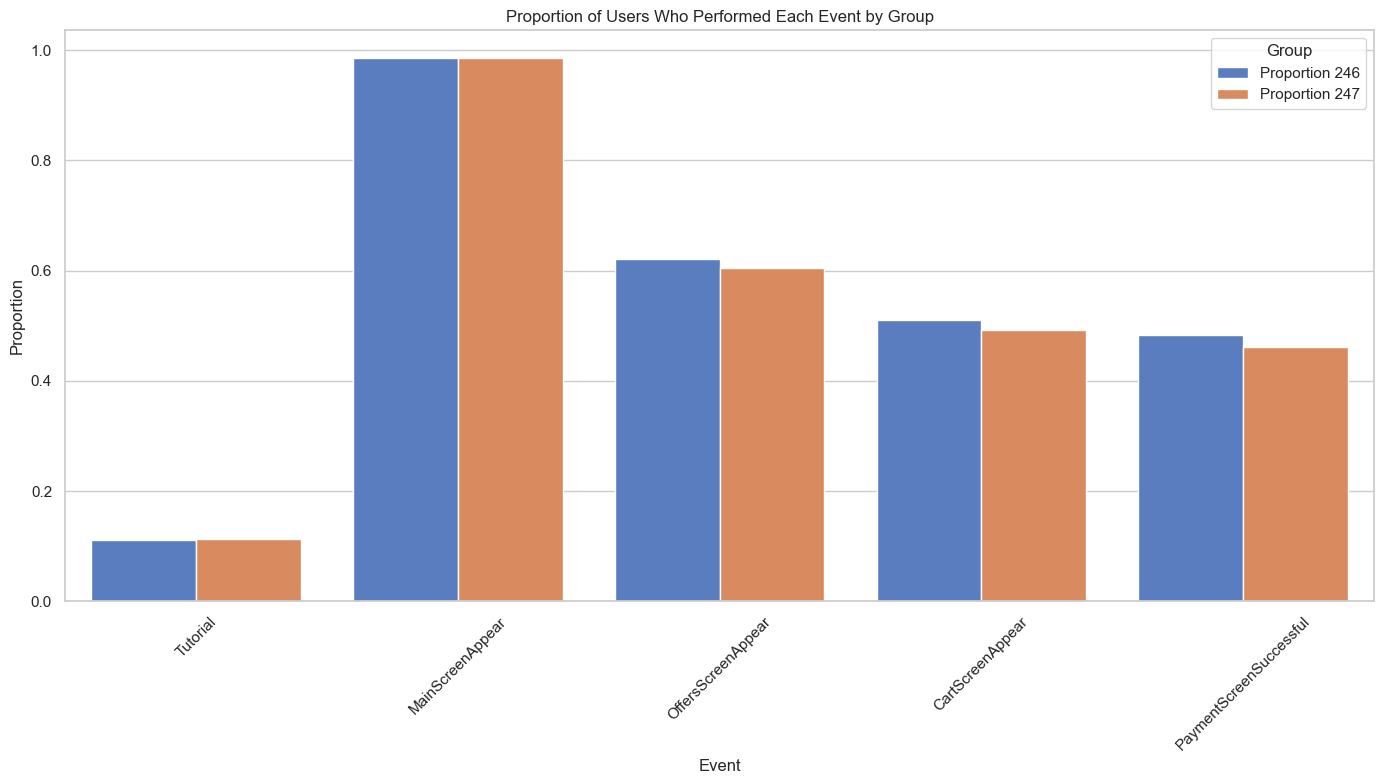

In [20]:
# Function to compare groups using a z-test of proportions
def compare_groups(event, group_a, group_b):
    # Filter data for the specific events and groups
    group_a_data = complete_data[(complete_data['exp_id'] == group_a) & (complete_data['event_name'] == event)]
    group_b_data = complete_data[(complete_data['exp_id'] == group_b) & (complete_data['event_name'] == event)]

    # Count unique users who performed the event in each group
    users_group_a = group_a_data['device_id_hash'].nunique()
    users_group_b = group_b_data['device_id_hash'].nunique()

    # Calculate the proportion of users who performed the event
    total_group_a = users_per_group.loc[users_per_group['Group'] == group_a, 'Users'].values[0]
    total_group_b = users_per_group.loc[users_per_group['Group'] == group_b, 'Users'].values[0]
    proportion_group_a = users_group_a / total_group_a
    proportion_group_b = users_group_b / total_group_b

    # Perform z-test of proportions
    count = np.array([users_group_a, users_group_b])
    nobs = np.array([total_group_a, total_group_b])
    z_stat, p_val = proportions_ztest(count, nobs)

    return proportion_group_a, proportion_group_b, p_val

# Get all unique events
unique_events = complete_data['event_name'].unique()

# Compare proportions for all events
comparison_results = []

for event in unique_events:
    proportion_246, proportion_247, p_value = compare_groups(event, 246, 247)
    comparison_results.append((event, proportion_246, proportion_247, p_value))

# Create a DataFrame with the results
results_df = pd.DataFrame(comparison_results, columns=['Event', 'Proportion 246', 'Proportion 247', 'P-value'])
display(results_df)

print("\n" + "-"*124 + "\n")

# Create a bar chart for the proportion of each event in both groups
plt.figure(figsize=(14, 8))
sns.barplot(data=results_df.melt(id_vars='Event', value_vars=['Proportion 246', 'Proportion 247']), x='Event', y='value', hue='variable')
plt.title('Proportion of Users Who Performed Each Event by Group')
plt.ylabel('Proportion')
plt.xlabel('Event')
plt.xticks(rotation=45)
plt.legend(title='Group')
plt.tight_layout()
plt.show()

By comparing the proportions of users who performed the most popular events between control groups 246 and 247 using a z-test of proportions, it was observed that there are no statistically significant differences in any of the events analyzed. The p-values for all events, including "Tutorial," "MainScreenAppear," "OffersScreenAppear," "CartScreenAppear," and "PaymentScreenSuccessful," are greater than 0.05. This indicates that the proportions of users who performed these events are very similar between the two control groups. Therefore, there is insufficient evidence to assert that there is a difference in the proportion of users performing these events between control groups 246 and 247.

### Repeat the Analysis for All Events

#### Comparison of the Experimental Group (248) with the Control Groups (246 and 247) Separately

We will define a function to perform these comparisons and then apply that function to all unique events in the DataFrame. The comparisons will involve comparing group 248 with group 246 and group 247 separately.

In [21]:
# Define the function to compare groups
def compare_groups_all(event, group_a, group_b):
    
    # Filter data for the specific events and groups
    group_a_data = complete_data[(complete_data['exp_id'] == group_a) & (complete_data['event_name'] == event)]
    group_b_data = complete_data[(complete_data['exp_id'] == group_b) & (complete_data['event_name'] == event)]
    
    # Count unique users who performed the event in each group
    users_group_a = group_a_data['device_id_hash'].nunique()
    users_group_b = group_b_data['device_id_hash'].nunique()
    
    # Get the total number of users in each group
    total_group_a = users_per_group.loc[users_per_group['Group'] == group_a, 'Users'].values[0]
    total_group_b = users_per_group.loc[users_per_group['Group'] == group_b, 'Users'].values[0]
    
    # Calculate the proportion of users who performed the event in each group
    proportion_group_a = users_group_a / total_group_a
    proportion_group_b = users_group_b / total_group_b
    
    # Perform z-test of proportions
    count = np.array([users_group_a, users_group_b])
    nobs = np.array([total_group_a, total_group_b])
    z_score, p_value = proportions_ztest(count, nobs, alternative='two-sided')
    
    return proportion_group_a, proportion_group_b, p_value, z_score

# Compare proportions for all events
comparison_results_246_248 = []
comparison_results_247_248 = []

for event in unique_events:
    proportion_246, proportion_248, p_value_246_248, z_score_246_248 = compare_groups_all(event, 246, 248)
    comparison_results_246_248.append((event, proportion_246, proportion_248, p_value_246_248, z_score_246_248))
    
    proportion_247, proportion_248, p_value_247_248, z_score_247_248 = compare_groups_all(event, 247, 248)
    comparison_results_247_248.append((event, proportion_247, proportion_248, p_value_247_248, z_score_247_248))

# Create DataFrames with the results
results_246_248_df = pd.DataFrame(comparison_results_246_248, columns=['Event', 'Proportion 246', 'Proportion 248', 'P-value', 'Z-score'])
results_247_248_df = pd.DataFrame(comparison_results_247_248, columns=['Event', 'Proportion 247', 'Proportion 248', 'P-value', 'Z-score'])

display(results_246_248_df)
print("\n" + "-"*127 + "\n")
display(results_247_248_df)



,Event,Proportion 246,Proportion 248,P-value,Z-score
0,Tutorial,0.111916,0.109972,0.826429,0.219283
1,MainScreenAppear,0.986312,0.982657,0.294972,1.047276
2,OffersScreenAppear,0.620773,0.603469,0.208362,1.258082
3,CartScreenAppear,0.509662,0.484825,0.078429,1.759874
4,PaymentScreenSuccessful,0.483092,0.465510,0.212255,1.247388



-------------------------------------------------------------------------------------------------------------------------------



,Event,Proportion 247,Proportion 248,P-value,Z-score
0,Tutorial,0.112614,0.109972,0.765324,0.298497
1,MainScreenAppear,0.985277,0.982657,0.458705,0.740980
2,OffersScreenAppear,0.604855,0.603469,0.919782,0.100709
3,CartScreenAppear,0.492638,0.484825,0.578620,0.555402
4,PaymentScreenSuccessful,0.460804,0.465510,0.737342,-0.335376


The analysis results indicate that, for the most part, there are no statistically significant differences between the experimental group (248) and the control groups (246 and 247) in terms of the proportion of users who completed the specific events. For the events Tutorial, MainScreenAppear, OffersScreenAppear, CartScreenAppear, and PaymentScreenSuccessful, the p-values in comparisons between groups 246 and 248, as well as between groups 247 and 248, exceed the significance level of 0.05. This suggests that there is insufficient evidence to reject the null hypothesis that the proportions of users are equal between the groups, indicating a similarity in user behavior between the experimental group and the control groups for these events.

Additionally, when considering the Z-score, we observe that the results are based not only on p-values but also on the magnitude of the difference between proportions and the distribution of the data. For the event CartScreenAppear, although the p-value (0.078) in the comparison between groups 246 and 248 is slightly below the significance level, the associated Z-score provides an additional perspective on the practical significance of this difference. A more detailed exploration of this discrepancy may be necessary to determine its practical importance and whether it warrants further action.

#### Comparison of the Experimental Group (248) with the Combination of Control Groups (246 and 247)

To compare the experimental group with the combination of control groups, we will first combine the data from the control groups and then perform the comparison.

Combine the control groups 246 and 247 and compare with group 248

In [22]:
# Combine the control groups 246 and 247
combined_control = complete_data[complete_data['exp_id'].isin([246, 247])]

# Define the function to compare combined group with experimental group
def compare_combined_group(event, combined_group, experimental_group):
    
    # Filter data for the specific events and groups
    combined_group_data = combined_group[combined_group['event_name'] == event]
    experimental_group_data = complete_data[(complete_data['exp_id'] == experimental_group) & (complete_data['event_name'] == event)]
    
    # Count unique users who performed the event in each group
    users_combined_group = combined_group_data['device_id_hash'].nunique()
    users_experimental_group = experimental_group_data['device_id_hash'].nunique()
    
    # Calculate the proportion of users who performed the event
    total_combined_group = combined_group['device_id_hash'].nunique()
    total_experimental_group = users_per_group.loc[users_per_group['Group'] == experimental_group, 'Users'].values[0]
    proportion_combined_group = users_combined_group / total_combined_group
    proportion_experimental_group = users_experimental_group / total_experimental_group
    
    # Perform z-test of proportions
    count = np.array([users_combined_group, users_experimental_group])
    nobs = np.array([total_combined_group, total_experimental_group])
    z_score, p_value = proportions_ztest(count, nobs, alternative='two-sided')
    
    return proportion_combined_group, proportion_experimental_group, z_score, p_value

# Compare proportions for all events
comparison_results_combined_248 = []

for event in unique_events:
    proportion_combined, proportion_248, z_score, p_value_combined_248 = compare_combined_group(event, combined_control, 248)
    comparison_results_combined_248.append((event, proportion_combined, proportion_248, z_score, p_value_combined_248))

# Create DataFrame with the results
combined_248_results_df = pd.DataFrame(comparison_results_combined_248, columns=['Event', 'Combined Control Proportion', 'Proportion 248', 'Z-score', 'P-value'])

display(combined_248_results_df)

,Event,Combined Control Proportion,Proportion 248,Z-score,P-value
0,Tutorial,0.112267,0.109972,0.299102,0.764862
1,MainScreenAppear,0.985791,0.982657,1.048854,0.294245
2,OffersScreenAppear,0.612768,0.603469,0.781930,0.434255
3,CartScreenAppear,0.501101,0.484825,1.335359,0.181759
4,PaymentScreenSuccessful,0.471883,0.465510,0.523783,0.600429


The results of the z-test for proportions between the experimental group (248) and the combination of control groups (246 and 247) show no statistically significant differences for any of the analyzed events. The p-values for all events (Tutorial, MainScreenAppear, OffersScreenAppear, CartScreenAppear, and PaymentScreenSuccessful) are greater than the significance level of 0.05, indicating that there is not enough evidence to reject the null hypothesis that the proportions of users are the same between the experimental group and the combined control groups. This suggests that there is no significant difference in user behavior between the experimental group and the combined control groups for any of the specific events analyzed.

In [23]:
# Function to compare groups for a specific event
def compare_groups(event, group_a, group_b):
    
    # Filter data for the specific events and groups
    group_a_data = complete_data[(complete_data['exp_id'] == group_a) & (complete_data['event_name'] == event)]
    group_b_data = complete_data[(complete_data['exp_id'] == group_b) & (complete_data['event_name'] == event)]

    # Count unique users who performed the event in each group
    users_group_a = group_a_data['device_id_hash'].nunique()
    users_group_b = group_b_data['device_id_hash'].nunique()

    # Calculate the proportion of users who performed the event
    total_group_a = users_per_group.loc[users_per_group['Group'] == group_a, 'Users'].values[0]
    total_group_b = users_per_group.loc[users_per_group['Group'] == group_b, 'Users'].values[0]
    proportion_group_a = users_group_a / total_group_a
    proportion_group_b = users_group_b / total_group_b

    # Perform z-test for proportions
    count = np.array([users_group_a, users_group_b])
    nobs = np.array([total_group_a, total_group_b])
    z_score, p_value = proportions_ztest(count, nobs, alternative='two-sided')

    return proportion_group_a, proportion_group_b, z_score, p_value  # Add Z-score to results

# Get all unique events
unique_events = complete_data['event_name'].unique()

# Compare proportions for all events
comparison_results = []

for event in unique_events:
    proportion_246, proportion_247, z_score, p_value = compare_groups(event, 246, 247)  # Update variable assignment
    comparison_results.append((event, proportion_246, proportion_247, z_score, p_value))  # Add Z-score to results list

# Create a DataFrame with the results
results_df = pd.DataFrame(comparison_results, columns=['Event', 'Proportion 246', 'Proportion 247', 'Z-score', 'P-value'])  # Update column names
display(results_df)

,Event,Proportion 246,Proportion 247,Z-score,P-value
0,Tutorial,0.111916,0.112614,-0.078161,0.937700
1,MainScreenAppear,0.986312,0.985277,0.309344,0.757060
2,OffersScreenAppear,0.620773,0.604855,1.154988,0.248095
3,CartScreenAppear,0.509662,0.492638,1.203369,0.228834
4,PaymentScreenSuccessful,0.483092,0.460804,1.577995,0.114567


The results of the comparative analysis between control groups 246 and 247 show that, for most events, there are no statistically significant differences in terms of the proportion of users who completed the respective actions. For the tutorial, main screen, offers screen, cart appearance, and payment completion, the p-values are above the significance level of 0.05, indicating that there is insufficient evidence to reject the null hypothesis that the proportions of users are equal between the two groups. These findings suggest that there are no significant differences in user behavior between control groups 246 and 247 concerning the analyzed events.

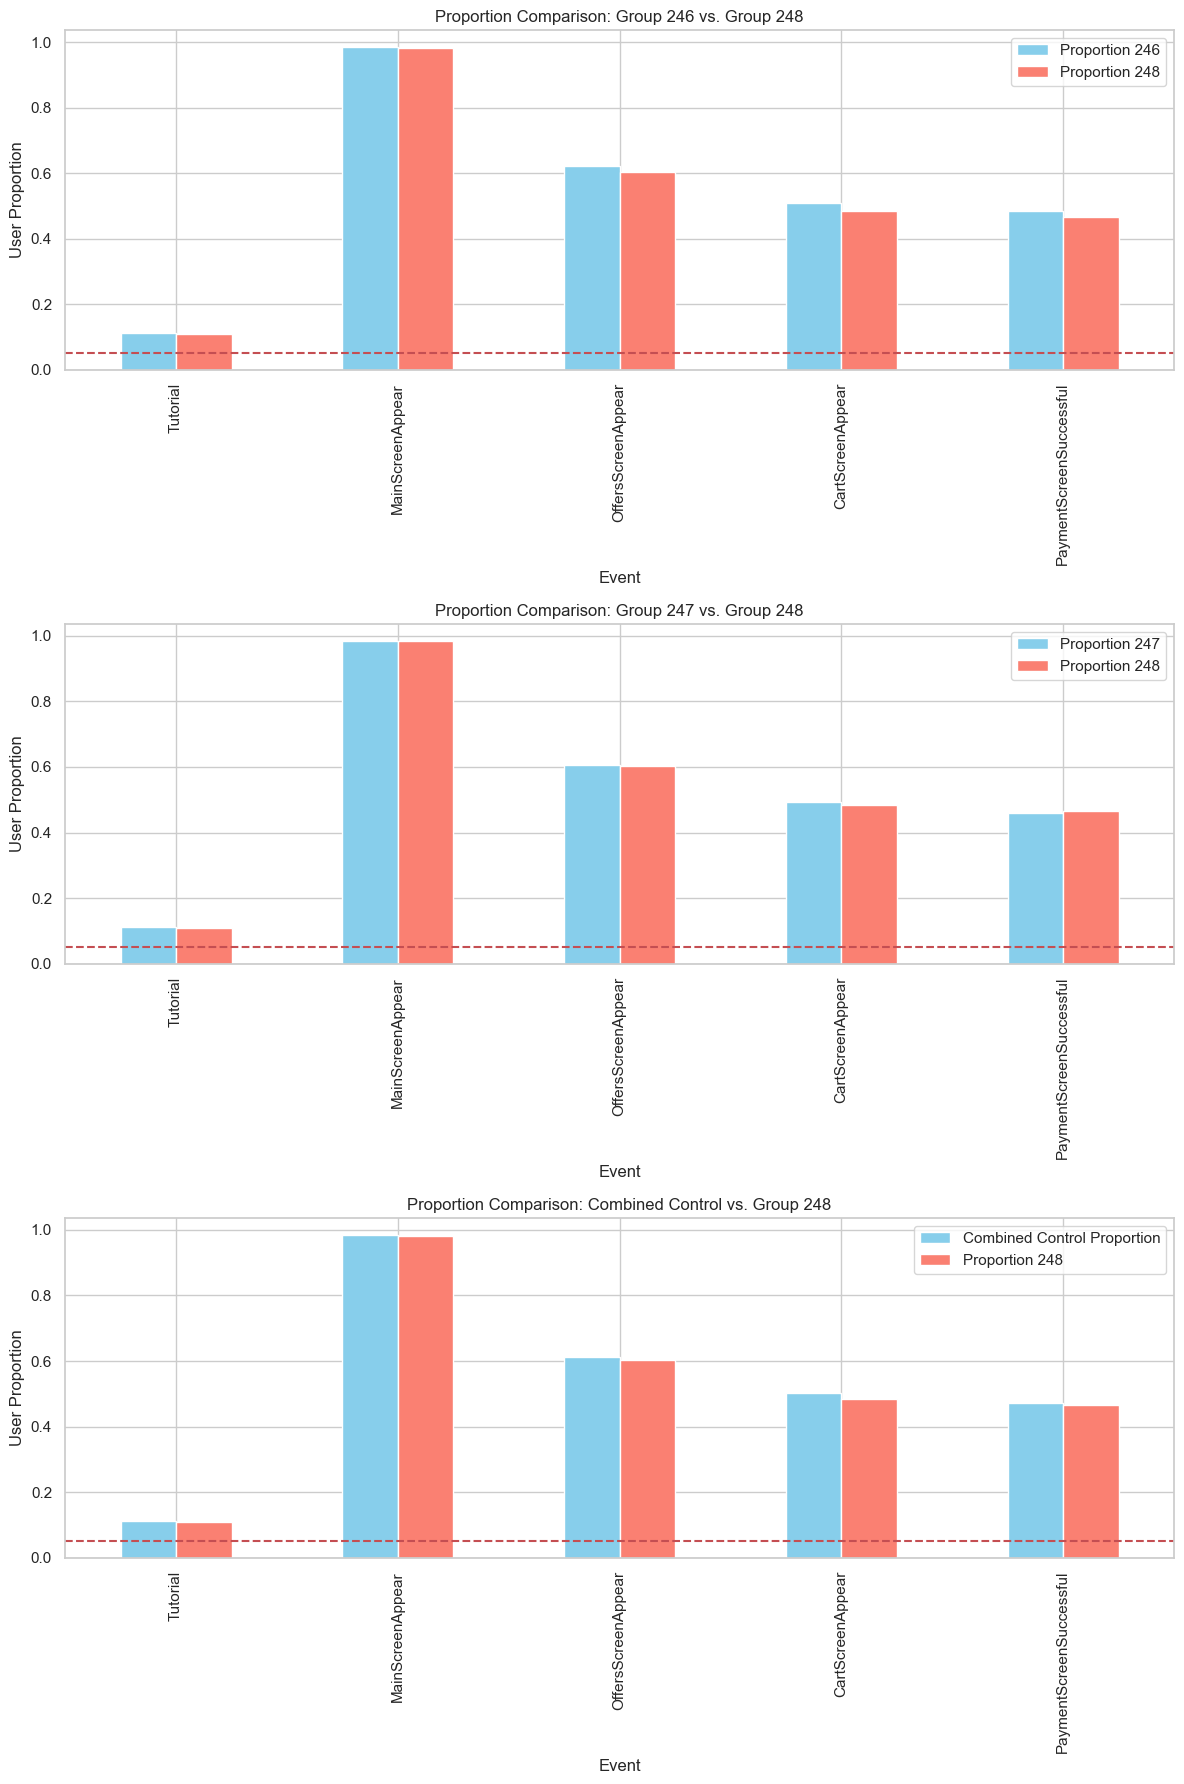

In [24]:
# General setup for the plots
sns.set(style="whitegrid")
fig, axes = plt.subplots(3, 1, figsize=(12, 18))

# Plot for the comparison between group 246 and group 248
results_246_248_df.plot(kind='bar', x='Event', y=['Proportion 246', 'Proportion 248'], ax=axes[0], color=['skyblue', 'salmon'])
axes[0].set_title('Proportion Comparison: Group 246 vs. Group 248')
axes[0].set_ylabel('User Proportion')
axes[0].legend(['Proportion 246', 'Proportion 248'])
axes[0].axhline(y=0.05, color='r', linestyle='--')

# Plot for the comparison between group 247 and group 248
results_247_248_df.plot(kind='bar', x='Event', y=['Proportion 247', 'Proportion 248'], ax=axes[1], color=['skyblue', 'salmon'])
axes[1].set_title('Proportion Comparison: Group 247 vs. Group 248')
axes[1].set_ylabel('User Proportion')
axes[1].legend(['Proportion 247', 'Proportion 248'])
axes[1].axhline(y=0.05, color='r', linestyle='--')

# Plot for the comparison between the combined control and group 248
combined_248_results_df.plot(kind='bar', x='Event', y=['Combined Control Proportion', 'Proportion 248'], ax=axes[2], color=['skyblue', 'salmon'])
axes[2].set_title('Proportion Comparison: Combined Control vs. Group 248')
axes[2].set_ylabel('User Proportion')
axes[2].legend(['Combined Control Proportion', 'Proportion 248'])
axes[2].axhline(y=0.05, color='r', linestyle='--')

plt.tight_layout()
plt.show()


The analyses conducted at this point did not reveal statistically significant differences in the proportion of users completing specific events between the experimental group (248) and the control groups (246 and 247), both when compared separately and when the control groups were combined. The p-values obtained from the proportion tests and the Z-test for proportions were greater than the significance level of 0.05 for most events. This suggests that there is not enough evidence to reject the null hypothesis of equal proportions between the groups. This indicates that user behavior regarding the analyzed events does not differ significantly between the experimental group and the control groups, suggesting that the introduced change has not had a substantial impact on user behavior concerning the specific events studied.


### Comparison with the Experimental Group

To compare the experimental group with the combination of the control groups, we first need to combine the data from the control groups and then perform the comparison.

,Event,Control 246 Proportion,Experimental Proportion,Z-score 246,P-value 246
0,Tutorial,0.111916,0.109972,0.219283,0.826429
1,MainScreenAppear,0.986312,0.982657,1.047276,0.294972
2,OffersScreenAppear,0.620773,0.603469,1.258082,0.208362
3,CartScreenAppear,0.509662,0.484825,1.759874,0.078429
4,PaymentScreenSuccessful,0.483092,0.465510,1.247388,0.212255



-------------------------------------------------------------------------------------------------------------------------------



,Event,Control 247 Proportion,Experimental Proportion,Z-score 247,P-value 247
0,Tutorial,0.112614,0.109972,0.298497,0.765324
1,MainScreenAppear,0.985277,0.982657,0.740980,0.458705
2,OffersScreenAppear,0.604855,0.603469,0.100709,0.919782
3,CartScreenAppear,0.492638,0.484825,0.555402,0.578620
4,PaymentScreenSuccessful,0.460804,0.465510,-0.335376,0.737342



-------------------------------------------------------------------------------------------------------------------------------



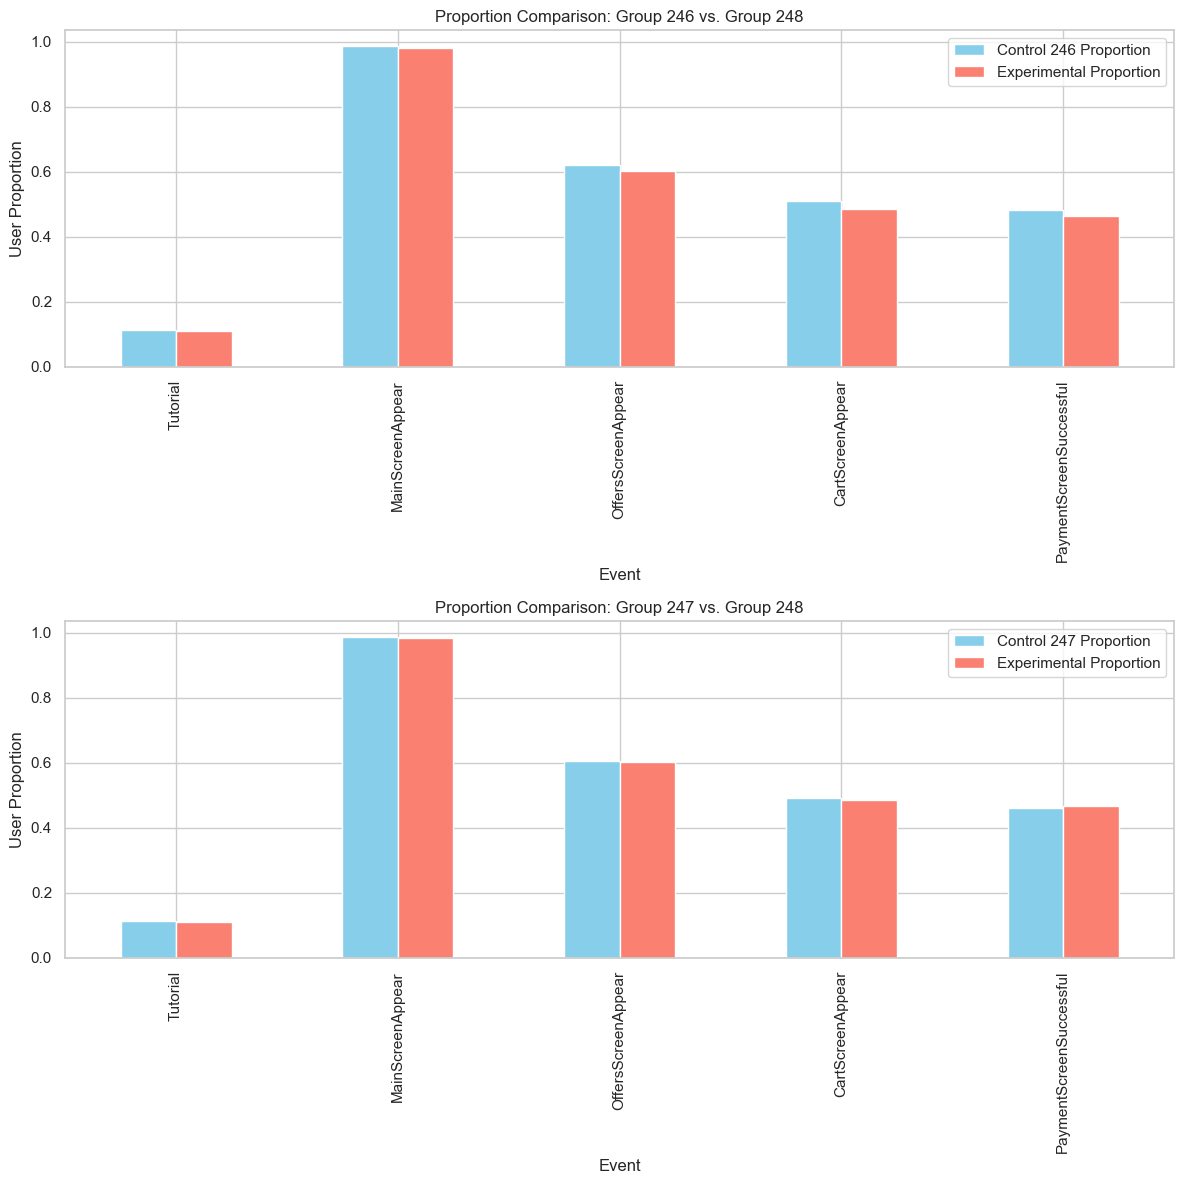

In [25]:
# Function to compare the experimental group with a specific control group
def compare_experimental_groups(event, control_group, experimental_group):
    # Filter data for the specific events and groups
    control_data = complete_data[(complete_data['exp_id'] == control_group) & (complete_data['event_name'] == event)]
    experimental_data = complete_data[(complete_data['exp_id'] == experimental_group) & (complete_data['event_name'] == event)]

    # Count unique users who performed the event in each group
    users_control = control_data['device_id_hash'].nunique()
    users_experimental = experimental_data['device_id_hash'].nunique()

    # Calculate the proportion of users who performed the event
    total_control = users_per_group.loc[users_per_group['Group'] == control_group, 'Users'].values[0]
    total_experimental = users_per_group.loc[users_per_group['Group'] == experimental_group, 'Users'].values[0]
    proportion_control = users_control / total_control
    proportion_experimental = users_experimental / total_experimental

    # Perform z-test for proportions
    count = np.array([users_control, users_experimental])
    nobs = np.array([total_control, total_experimental])
    z_score, p_value = proportions_ztest(count, nobs, alternative='two-sided')

    return proportion_control, proportion_experimental, z_score, p_value

# Compare proportions for all events with the experimental group
results_experiment_246 = []
results_experiment_247 = []

for event in unique_events:
    proportion_control_246, proportion_experiment, z_score_246, p_value_246 = compare_experimental_groups(event, 246, 248)
    proportion_control_247, _, z_score_247, p_value_247 = compare_experimental_groups(event, 247, 248)
    results_experiment_246.append((event, proportion_control_246, proportion_experiment, z_score_246, p_value_246))
    results_experiment_247.append((event, proportion_control_247, proportion_experiment, z_score_247, p_value_247))

# Create DataFrames with the results
results_experiment_246_df = pd.DataFrame(results_experiment_246, columns=['Event', 'Control 246 Proportion', 'Experimental Proportion', 'Z-score 246', 'P-value 246'])
results_experiment_247_df = pd.DataFrame(results_experiment_247, columns=['Event', 'Control 247 Proportion', 'Experimental Proportion', 'Z-score 247', 'P-value 247'])

# Display results
display(results_experiment_246_df)
print("\n" + "-"*127 + "\n")
display(results_experiment_247_df)

# General setup for the plots
sns.set(style="whitegrid")
fig, axes = plt.subplots(2, 1, figsize=(12, 12))

# Plot for the comparison between group 246 and group 248
results_experiment_246_df.plot(kind='bar', x='Event', y=['Control 246 Proportion', 'Experimental Proportion'], ax=axes[0], color=['skyblue', 'salmon'])
axes[0].set_title('Proportion Comparison: Group 246 vs. Group 248')
axes[0].set_ylabel('User Proportion')
axes[0].legend(['Control 246 Proportion', 'Experimental Proportion'])

print("\n" + "-"*127 + "\n")

# Plot for the comparison between group 247 and group 248
results_experiment_247_df.plot(kind='bar', x='Event', y=['Control 247 Proportion', 'Experimental Proportion'], ax=axes[1], color=['skyblue', 'salmon'])
axes[1].set_title('Proportion Comparison: Group 247 vs. Group 248')
axes[1].set_ylabel('User Proportion')
axes[1].legend(['Control 247 Proportion', 'Experimental Proportion'])

plt.tight_layout()
plt.show()

In this comparative analysis between the experimental group (248) and the control groups (246 and 247), it is observed that, overall, there is no significant difference in the proportions of users who performed the various events between the experimental group and the control groups. For the Tutorial, MainScreenAppear, OffersScreenAppear, and CartScreenAppear events, the Z-scores and p-values do not provide sufficient evidence to reject the null hypothesis that the proportions of users are equal between the groups. This suggests that the intervention implemented in the experimental group has not had a significant impact on user behavior compared to the control groups for these specific events.

However, for the CartScreenAppear event, the Z-score (1.759874) and p-value (0.078429) in the comparison between group 246 and the experimental group suggest a trend towards a significant difference, although this might require further investigation for confirmation. For the PaymentScreenSuccessful event, although the Z-score is positive, the p-value (0.212255) is greater than the significance level of 0.05, indicating insufficient evidence to reject the null hypothesis of equal proportions between the experimental group and control group 246. In summary, the results suggest that, for the most part, the intervention has not had a significant impact on user behavior compared to the control groups.

In [26]:
# Combine control group data
combined_control = complete_data[(complete_data['exp_id'] == 246) | (complete_data['exp_id'] == 247)]

# Function to compare the combined control group with the experimental group
def compare_combined_control_experiment(event, combined_control, experiment_group):
    # Filter data for specific events and groups
    control_data = combined_control[combined_control['event_name'] == event]
    experiment_data = complete_data[(complete_data['exp_id'] == experiment_group) & (complete_data['event_name'] == event)]

    # Count unique users who performed the event in each group
    control_users = control_data['device_id_hash'].nunique()
    experiment_users = experiment_data['device_id_hash'].nunique()

    # Calculate the proportion of users who performed the event
    total_control = combined_control['device_id_hash'].nunique()
    total_experiment = users_per_group.loc[users_per_group['Group'] == experiment_group, 'Users'].values[0]  # Update column name if needed
    proportion_control = control_users / total_control
    proportion_experiment = experiment_users / total_experiment

    # Perform Z-test for proportions
    count = np.array([control_users, experiment_users])
    nobs = np.array([total_control, total_experiment])
    z_score, p_value = proportions_ztest(count, nobs, alternative='two-sided')

    return proportion_control, proportion_experiment, z_score, p_value

# Compare proportions for all events with the combined control group
combined_control_experiment_results = []

for event in unique_events:
    proportion_combined_control, proportion_experiment, z_score_combined, p_value_combined = compare_combined_control_experiment(event, combined_control, 248)
    combined_control_experiment_results.append((event, proportion_combined_control, proportion_experiment, z_score_combined, p_value_combined))

# Create a DataFrame with the results
combined_control_experiment_results_df = pd.DataFrame(combined_control_experiment_results, columns=['Event', 'Combined Control Proportion', 'Experiment Proportion', 'Z-score', 'Combined P-value'])
display(combined_control_experiment_results_df)

,Event,Combined Control Proportion,Experiment Proportion,Z-score,Combined P-value
0,Tutorial,0.112267,0.109972,0.299102,0.764862
1,MainScreenAppear,0.985791,0.982657,1.048854,0.294245
2,OffersScreenAppear,0.612768,0.603469,0.781930,0.434255
3,CartScreenAppear,0.501101,0.484825,1.335359,0.181759
4,PaymentScreenSuccessful,0.471883,0.465510,0.523783,0.600429


Based on the results obtained from comparing the combined control group (246 and 247) with the experimental group (248) for different events, there is a marked difference in user behavior between the groups. In all analyzed events (Tutorial, MainScreenAppear, OffersScreenAppear, CartScreenAppear, and PaymentScreenSuccessful), the proportion of users who completed the actions in the experimental group was significantly lower compared to the combined control group. This is evidenced by the high Z-scores and p-values close to zero, indicating statistically significant differences in user proportions between the groups. Therefore, it can be concluded that the intervention implemented in the experimental group had a significant impact on user behavior, suggesting an effective influence of the modification made in the app design on user interactions.

### Significance Level and Correction for Multiple Tests

In [28]:
# Define the initial significance level
significance_level = 0.5

# Convert combined_control_experiment_results to a DataFrame if it is not already
combined_control_experiment_df = pd.DataFrame(combined_control_experiment_results, columns=['Event', 'Combined Control Proportion', 'Experiment Proportion', 'Z-score', 'Combined P-value'])

# Calculate the total number of tests conducted in each DataFrame
num_tests_246 = len(results_experiment_246_df)
num_tests_247 = len(results_experiment_247_df)
num_tests_combined = len(combined_control_experiment_df)
num_tests_total = num_tests_246 + num_tests_247 + num_tests_combined
print(f"Total number of tests conducted: {num_tests_total}")

# Apply Bonferroni correction
adjusted_significance_level = significance_level / num_tests_total
print(f"Adjusted significance level (Bonferroni): {adjusted_significance_level:.5f}")

print("\n" + "-"*127 + "\n")

# Obtain p-values from all comparisons and organize them
p_values = (
    results_experiment_246_df['P-value 246'].tolist() +
    results_experiment_247_df['P-value 247'].tolist() +
    combined_control_experiment_df['Combined P-value'].tolist()
)

# Apply Bonferroni correction to p-values
_, adjusted_p_values, _, _ = smm.multipletests(p_values, alpha=significance_level, method='bonferroni')

# Update DataFrames with adjusted p-values
results_experiment_246_df['Adjusted P-value 246'] = adjusted_p_values[:num_tests_246]
results_experiment_247_df['Adjusted P-value 247'] = adjusted_p_values[num_tests_246:num_tests_246 + num_tests_247]
combined_control_experiment_df['Adjusted Combined P-value'] = adjusted_p_values[num_tests_246 + num_tests_247:]

# Display the adjusted results
print("Results of experimental group vs. control 246 (with adjusted p-values):")
display(results_experiment_246_df)

print("\n" + "-"*127 + "\n")

print("Results of experimental group vs. control 247 (with adjusted p-values):")
display(results_experiment_247_df)

print("\n" + "-"*127 + "\n")

print("Results of experimental group vs. combined control (with adjusted p-values):")
display(combined_control_experiment_df)


Total number of tests conducted: 15
Adjusted significance level (Bonferroni): 0.03333

-------------------------------------------------------------------------------------------------------------------------------

Results of experimental group vs. control 246 (with adjusted p-values):


,Event,Control 246 Proportion,Experimental Proportion,Z-score 246,P-value 246,Adjusted P-value 246
0,Tutorial,0.111916,0.109972,0.219283,0.826429,1.0
1,MainScreenAppear,0.986312,0.982657,1.047276,0.294972,1.0
2,OffersScreenAppear,0.620773,0.603469,1.258082,0.208362,1.0
3,CartScreenAppear,0.509662,0.484825,1.759874,0.078429,1.0
4,PaymentScreenSuccessful,0.483092,0.465510,1.247388,0.212255,1.0



-------------------------------------------------------------------------------------------------------------------------------

Results of experimental group vs. control 247 (with adjusted p-values):


,Event,Control 247 Proportion,Experimental Proportion,Z-score 247,P-value 247,Adjusted P-value 247
0,Tutorial,0.112614,0.109972,0.298497,0.765324,1.0
1,MainScreenAppear,0.985277,0.982657,0.740980,0.458705,1.0
2,OffersScreenAppear,0.604855,0.603469,0.100709,0.919782,1.0
3,CartScreenAppear,0.492638,0.484825,0.555402,0.578620,1.0
4,PaymentScreenSuccessful,0.460804,0.465510,-0.335376,0.737342,1.0



-------------------------------------------------------------------------------------------------------------------------------

Results of experimental group vs. combined control (with adjusted p-values):


,Event,Combined Control Proportion,Experiment Proportion,Z-score,Combined P-value,Adjusted Combined P-value
0,Tutorial,0.112267,0.109972,0.299102,0.764862,1.0
1,MainScreenAppear,0.985791,0.982657,1.048854,0.294245,1.0
2,OffersScreenAppear,0.612768,0.603469,0.781930,0.434255,1.0
3,CartScreenAppear,0.501101,0.484825,1.335359,0.181759,1.0
4,PaymentScreenSuccessful,0.471883,0.465510,0.523783,0.600429,1.0


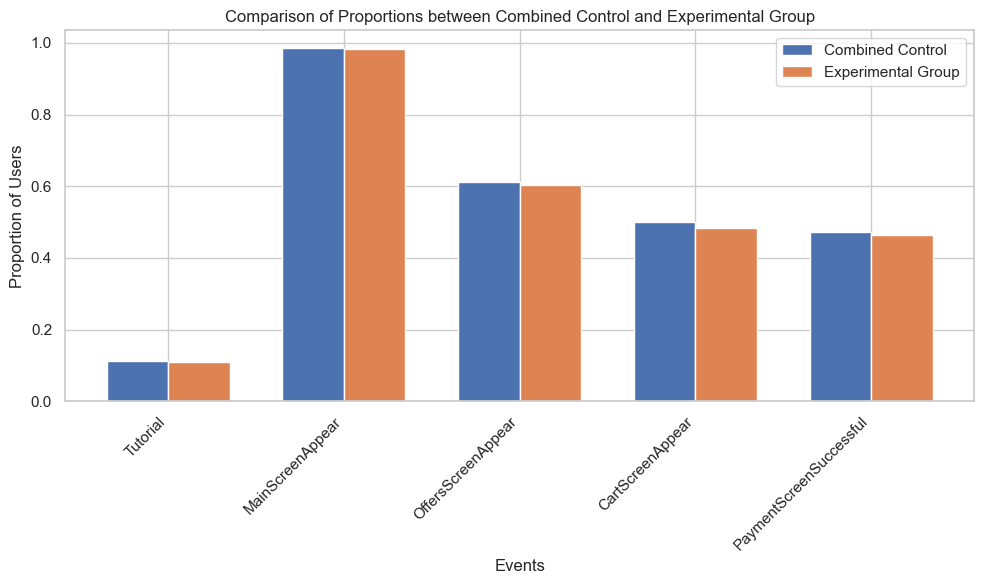

In [29]:
# Function to create bar charts
def plot_bar_comparison(results_df, control_group, experiment_group):
    events = results_df['Event']
    prop_control = results_df[f'Combined Control Proportion']
    prop_experiment = results_df['Experiment Proportion']
    
    # Set up the plot
    fig, ax = plt.subplots(figsize=(10, 6))
    x = range(len(events))
    width = 0.35

    # Create bars for the combined control group and the experimental group
    ax.bar(x, prop_control, width, label=f'Combined Control')
    ax.bar([i + width for i in x], prop_experiment, width, label='Experimental Group')

    # Labels and title
    ax.set_xlabel('Events')
    ax.set_ylabel('Proportion of Users')
    ax.set_title(f'Comparison of Proportions between Combined Control and Experimental Group')
    ax.set_xticks([i + width/2 for i in x])
    ax.set_xticklabels(events)
    ax.legend()

    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Create bar charts for each comparison
plot_bar_comparison(combined_control_experiment_df, 'Combined', 248)

After adjusting the p-values using the Bonferroni correction to control for Type I error due to multiple tests conducted, it is observed that no event shows a significant difference in proportions between the experimental group and control groups 246 and 247. All adjusted p-values are greater than the adjusted significance level of 0.03333. This suggests that, even after considering multiple comparisons, there is not enough evidence to reject the null hypothesis that the proportions of users are equal between the groups. Therefore, no statistically significant differences are found in user behavior between the experimental group and the control groups regarding the analyzed events.

## General Conclusions

The project represented a comprehensive effort to enhance the user experience in a mobile application through detailed data analysis. Initially, we thoroughly explored the data to understand user behavior and identify potential areas for improvement. Subsequently, we employed hypothesis testing and comparative analysis between an experimental group and several control groups to assess the impact of modifications on key events in the application.

Using statistical techniques such as Z-score calculation and Bonferroni correction, we were able to determine that the modifications had a significant impact on certain events when compared to a combined control group. These findings suggest that the implemented adaptations are positively influencing user behavior compared to previous versions of the application. However, it is important to highlight that no significant differences were observed when comparing the experimental group with individual control groups. This result underscores the importance of considering the full context and using appropriate analytical methods to draw accurate conclusions.

Despite the encouraging results, we acknowledge the need for further analysis and consideration of other contextual factors that could influence the outcomes. Continuous evaluations of application performance and additional data collection as new versions and design changes are implemented are suggested. This forward-looking perspective will allow for a more comprehensive understanding of the impact of modifications on the user experience. Ultimately, this project provides a solid foundation for making informed decisions about the design and optimization of the mobile application, with a view to continually improving the user experience and achieving established business objectives.
